In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import sklearn
import dropkick as dk
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.5 scipy==1.8.0 pandas==1.4.2 scikit-learn==1.1.0 statsmodels==0.13.2 python-igraph==0.9.10 pynndescent==0.5.7


## scanpy preprocessing

In [2]:
# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
# !mkdir write

In [3]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


In [4]:
adata.var_names_make_unique() 
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.tl.leiden(adata, resolution=1.5, key_added="cluster2")

filtered out 19024 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


/home/wan268/.conda/envs/test_scvi16_cuda113/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:09)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 40


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 15 clusters and added
    'cluster2', the cluster labels (adata.obs, categorical) (0:00:00)


In [5]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cluster2'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

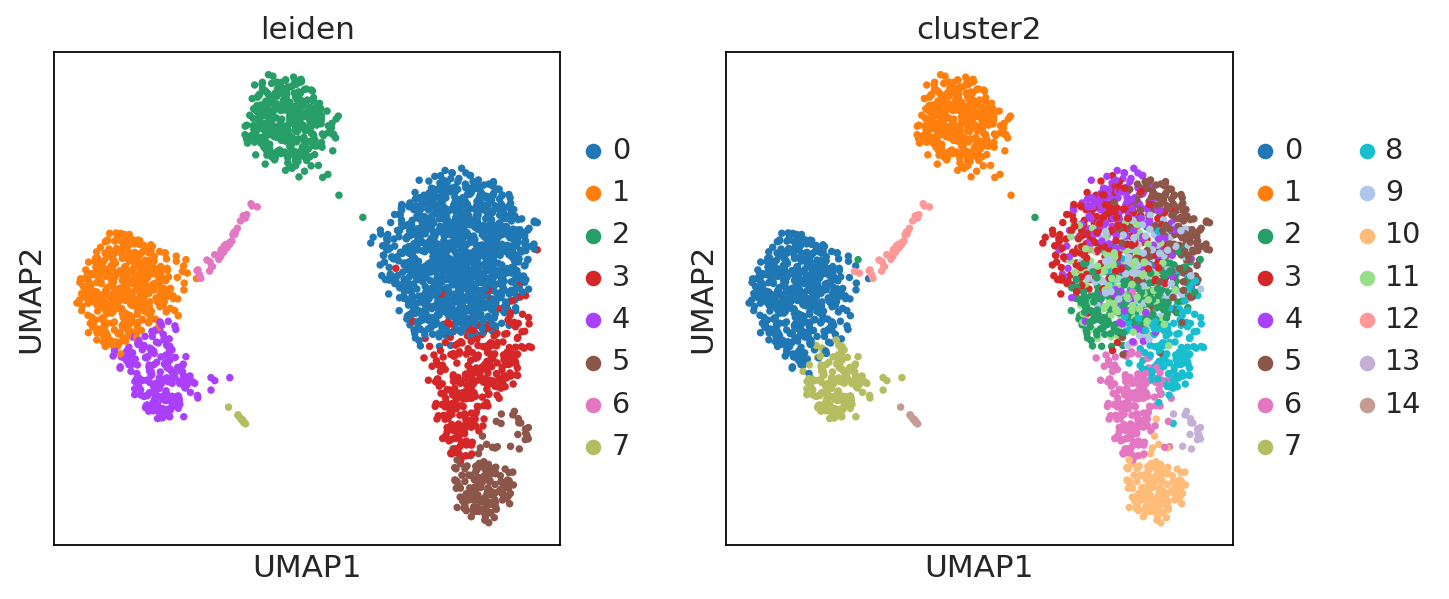

In [6]:
sc.pl.umap(adata, color=['leiden','cluster2'])

##  Dropkick processing

In [7]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


In [8]:
adata = dk.recipe_dropkick(adata, n_hvgs=None, X_final="raw_counts")

filtered out 16104 genes that are detected in less than 1 counts
Ignoring 16104 genes with zero total counts
Top 10 ambient genes have dropout rates between 0.0 and 0.37 percent:
	['TMSB4X', 'B2M', 'MALAT1', 'RPL13A', 'RPL10', 'RPL13', 'RPLP1', 'RPS2', 'RPL11', 'RPS18']
normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


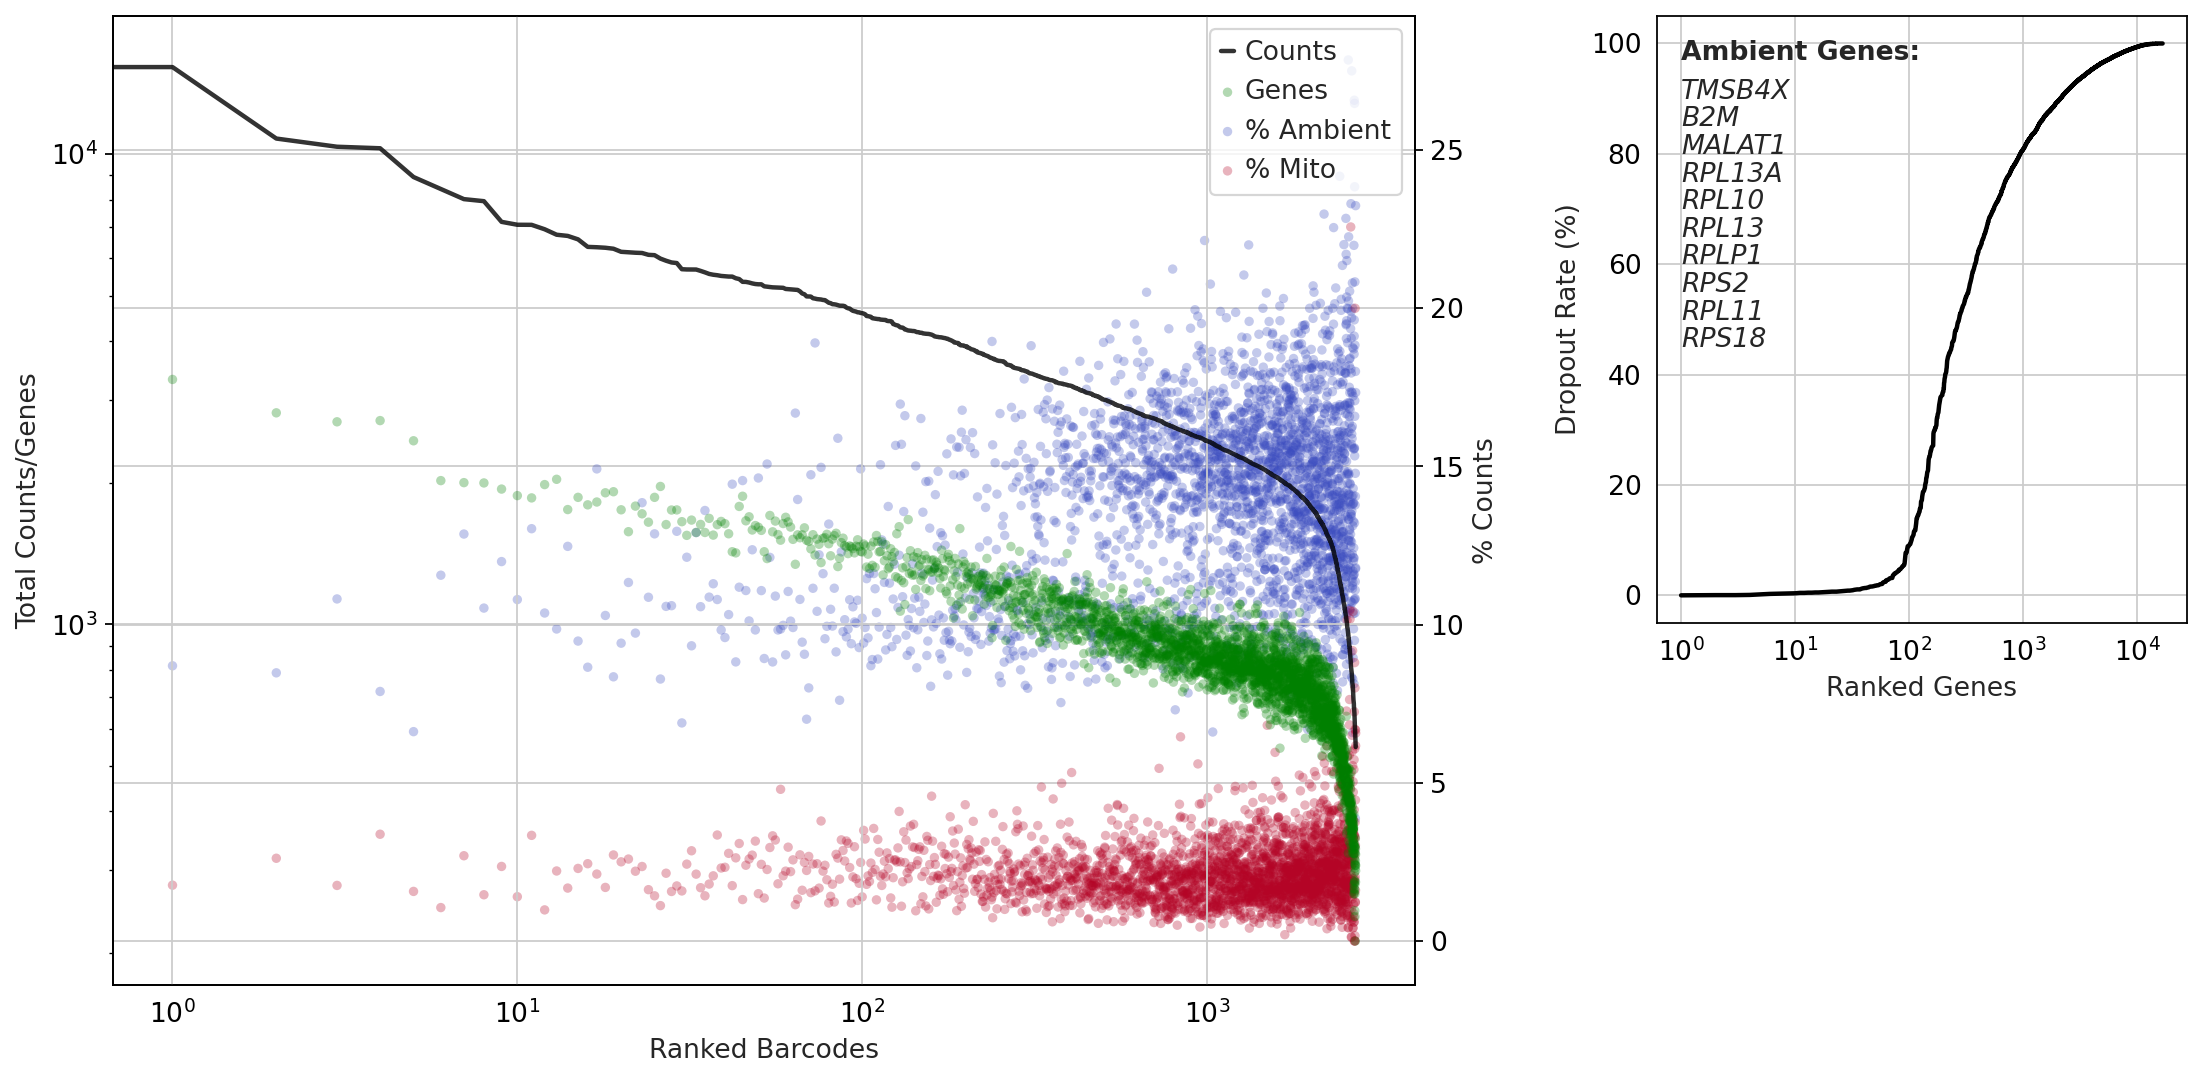

In [9]:
qc_plt = dk.qc_summary(adata)

### Run dropkick pipeline function

In [10]:
%time adata_model = dk.dropkick(adata, n_jobs=5)

Top 10 ambient genes have dropout rates between 0.0 and 0.37 percent:
	['TMSB4X', 'B2M', 'MALAT1', 'RPL13A', 'RPL10', 'RPL13', 'RPLP1', 'RPS2', 'RPL11', 'RPS18']
normalizing counts per cell
    finished (0:00:00)
Determining 2000 highly variable genes
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
Setting arcsinh_norm layer to .X
Thresholding on heuristics for training labels:
	['arcsinh_n_genes_by_counts']
Ignoring 420 barcodes below first threshold on arcsinh_n_genes_by_counts
Training dropkick with alphas:
	[0.1]


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float v

[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    5.4s remaining:    8.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    5.5s finished


Chosen lambda value:
	[0.09300081]
Assigning scores and labels
Done!

CPU times: user 28.3 s, sys: 1.21 s, total: 29.5 s
Wall time: 12.5 s


In [11]:
adata_filtered = adata[adata.obs.dropkick_label == 'False'].copy()
adata_filtered

AnnData object with n_obs × n_vars = 2309 × 16634
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_mito', 'pct_counts_ambient', 'arcsinh_total_counts', 'arcsinh_n_genes_by_counts', 'dropkick_score', 'dropkick_label'
    var: 'gene_ids', 'mito', 'pct_dropout_by_counts', 'ambient', 'n_cells_by_counts', 'mean_counts', 'total_counts', 'mean', 'std', 'dropkick_coef'
    uns: 'dropkick_thresholds', 'dropkick_args'
    layers: 'raw_counts', 'arcsinh_norm'

### Compare Dropkick output with Scanpy workflow

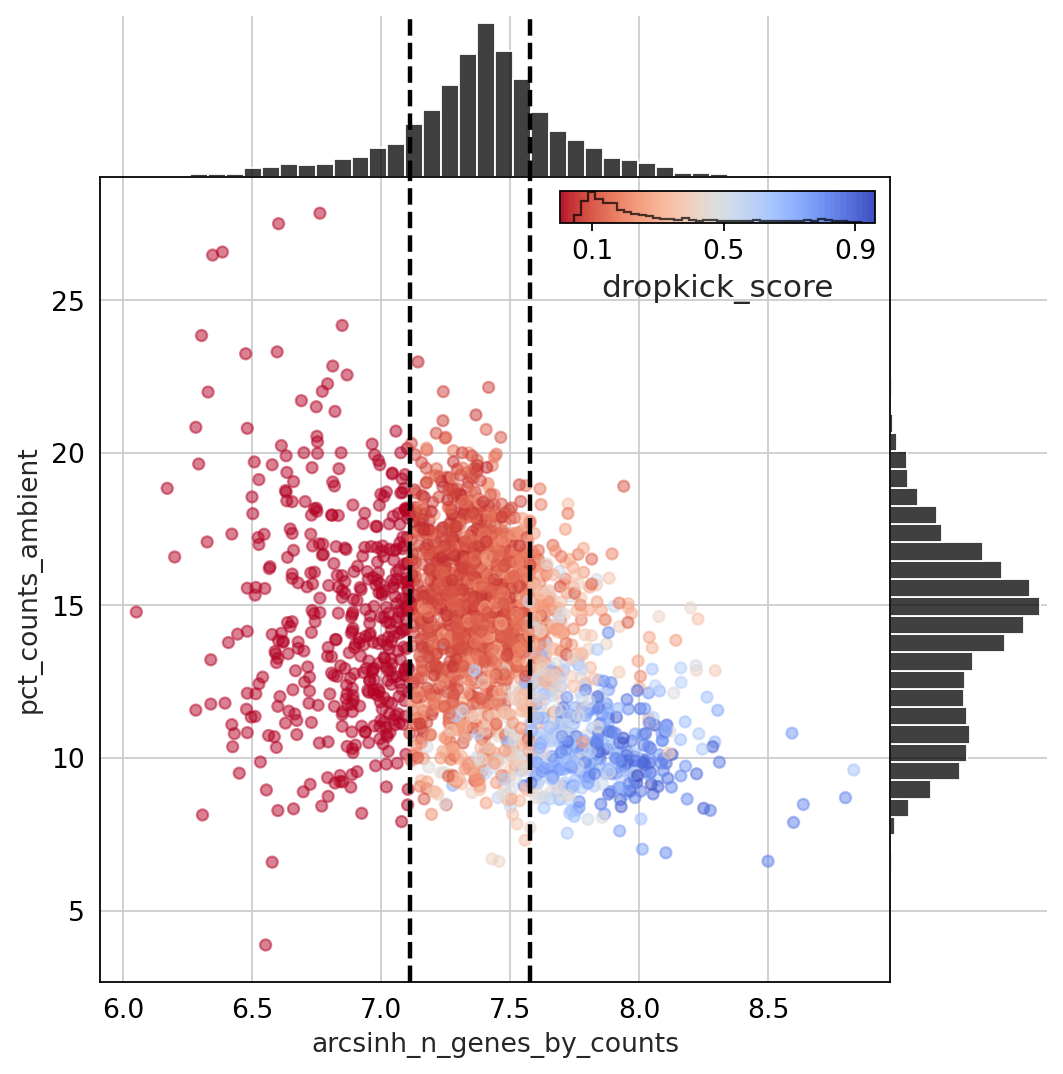

In [12]:
score_plt = dk.score_plot(adata)

### scanpy downstream processing on raw object

In [13]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.tl.leiden(adata, resolution=1.5, key_added="cluster2")

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:06)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 15

### Dropkick downstream processing

In [14]:
adata_filtered = dk.recipe_dropkick(adata_filtered, X_final="arcsinh_norm", filter=True, n_hvgs=2000, verbose=True)
sc.pp.neighbors(adata_filtered, n_neighbors=30, random_state=1, n_pcs=10)
sc.tl.leiden(adata_filtered)
sc.tl.umap(adata_filtered, random_state=1)

filtered out 605 genes that are detected in less than 1 counts
Ignoring 605 genes with zero total counts
Top 10 ambient genes have dropout rates between 0.0 and 0.433 percent:
	['TMSB4X', 'B2M', 'MALAT1', 'RPL13A', 'RPL10', 'RPL13', 'RPLP1', 'RPS2', 'RPL11', 'RPS18']
normalizing counts per cell
    finished (0:00:00)
Determining 2000 highly variable genes
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
Setting arcsinh_norm layer to .X
computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:03)
    finished: added to `.uns['neighbors']`
    `.obsp['distance

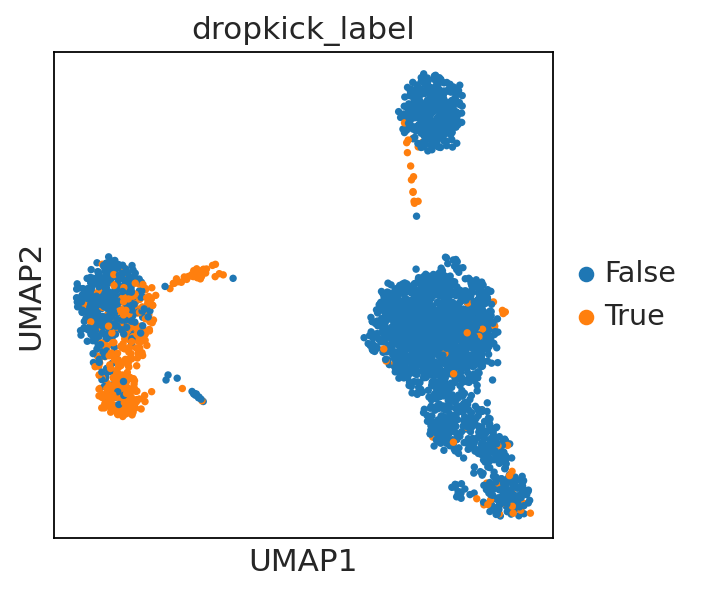

In [15]:
sc.pl.umap(adata, color=['dropkick_label'])

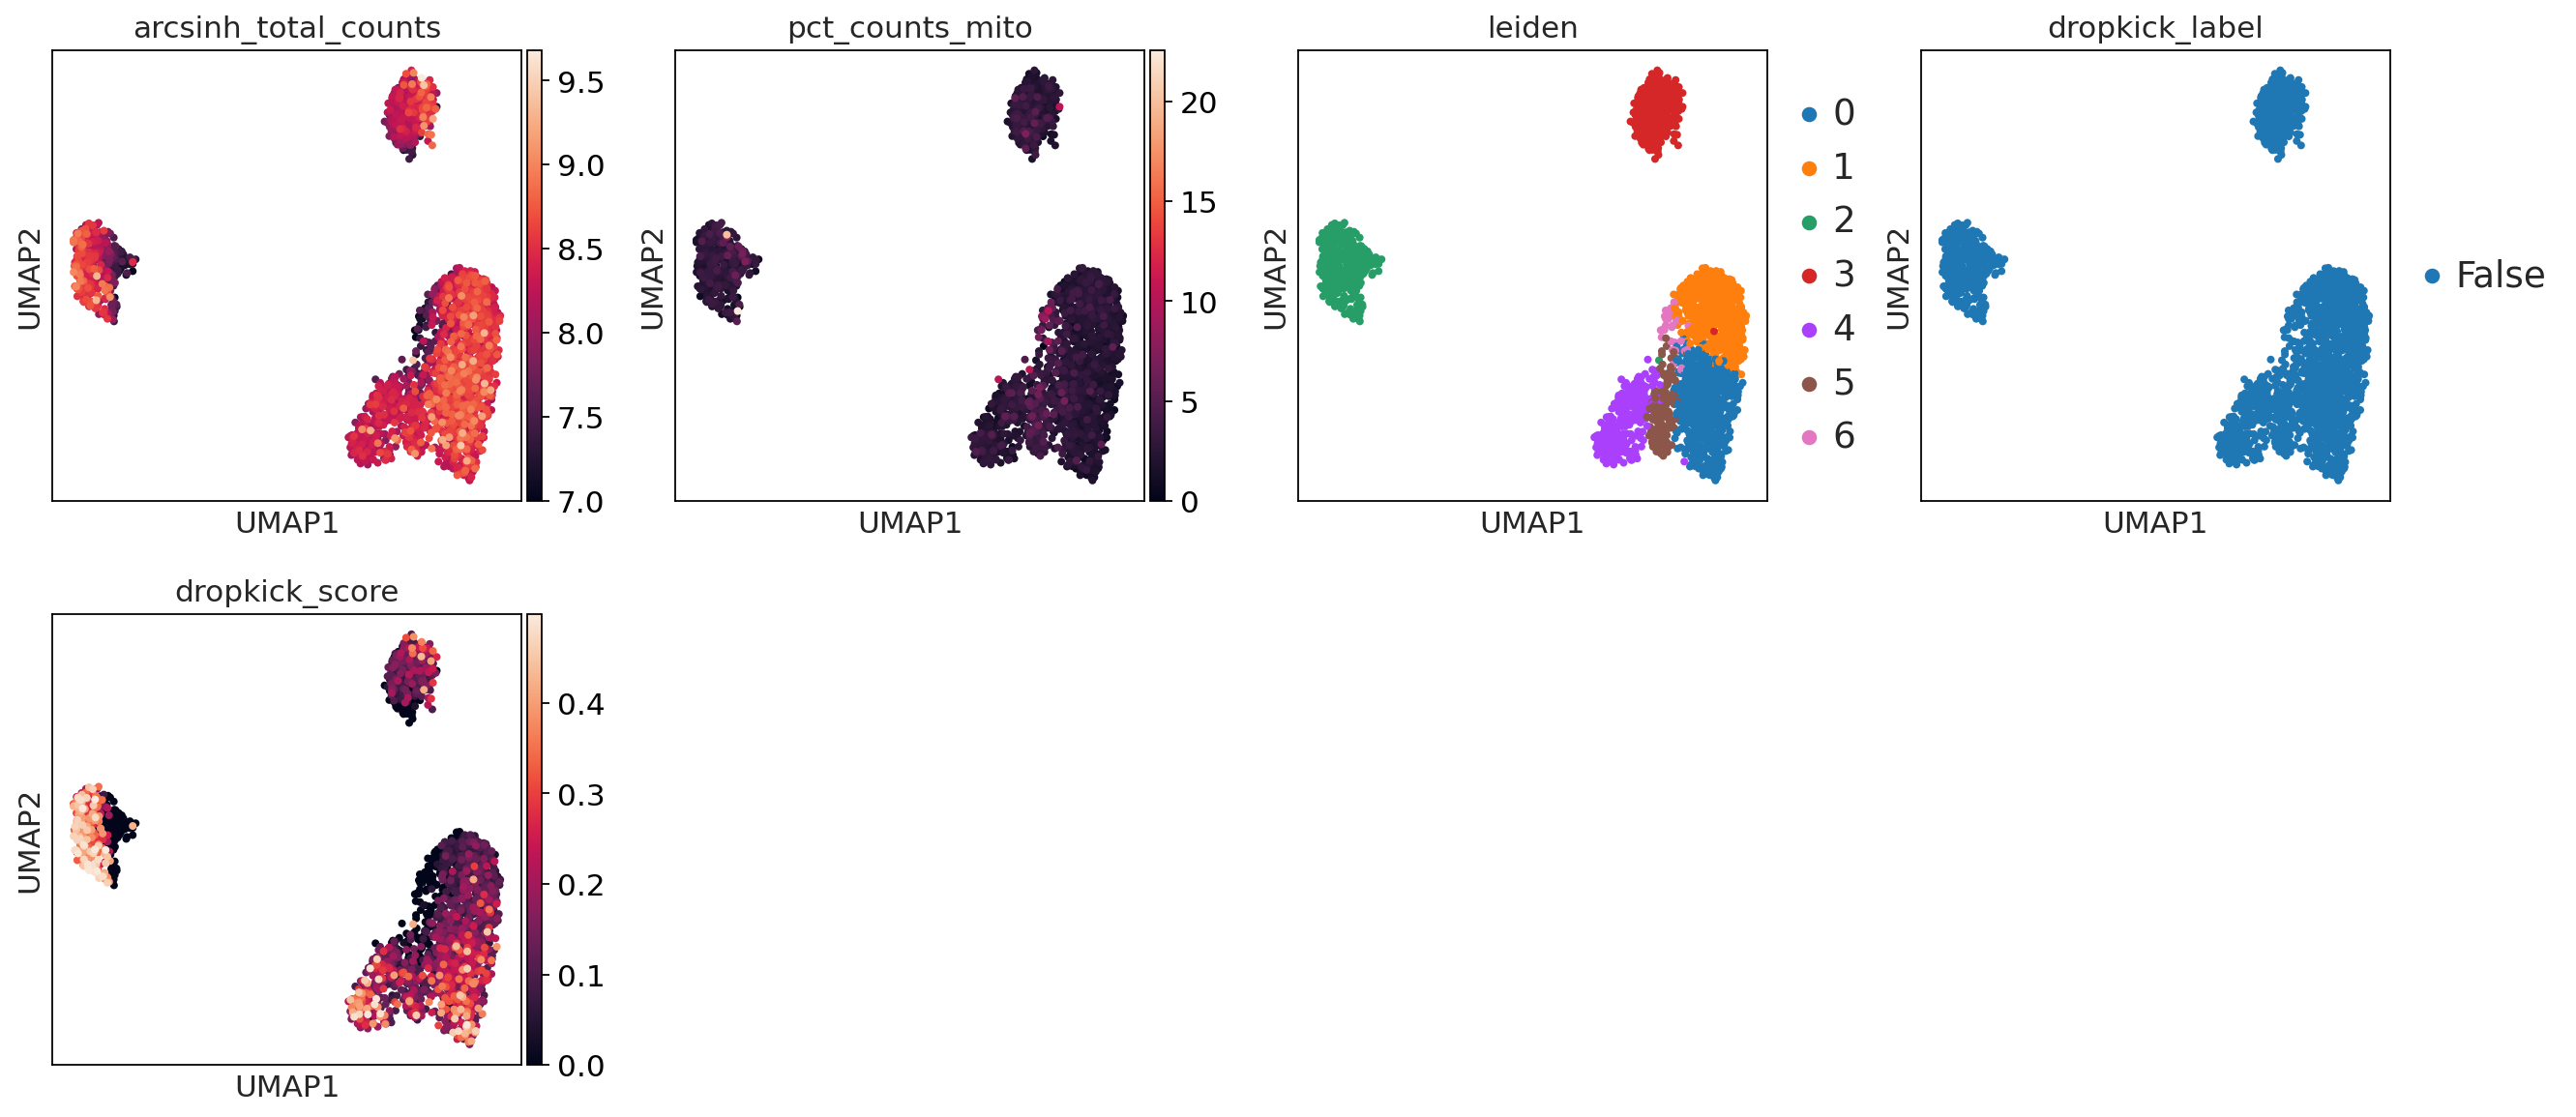

In [16]:
sc.pl.umap(
    adata_filtered,
    color=[
        "arcsinh_total_counts",
        "pct_counts_mito",
        "leiden",
        "dropkick_label",
        "dropkick_score",
    ],
    legend_fontsize="large",
    ncols=4,
)